### Erddap Quicklooks of EnvPlotter - Tester

__pyversion__==3.7   
__author__==S.Bell

__Notes:__ 

```
Home (shop) Station:   
Full Scale details... temp better at 25degC

DHT11 - 0-50C +/- 2degC, 0.1
      - 20-90% +/- 5%, 1
      
BMP180 - temp is +/- 2degc
       - baro is +/- 1hpa (and a 1hpa res for relative?)
       
--

Office Station - SParkFun redboard with BME280 T/RH/P
               - UV Sensor (VEML6075)
               
               - 20-80% RH is +/- 3%
               - baro is +/- 1hpa
               - temp is +/- 0.5degc
               
Lab EnvStation - SParkFun redboard with BME280 T/RH/P
               - CCSS8211 (AQ Sensor - eCO2 and VOC :  has collocated BME280 as well)
               
               - 20-80% RH is +/- 3%
               - baro is +/- 1hpa
               - temp is +/- 0.5degc
```

*relocation history*
- initially beside downdraft in back corner of office (until Jan?) UV data may indicate when moved
- moved to front side of fish tank (lamp may be slightly heating it) based on increase in temp when i arrive at office but no increase on remote work days... previous location appeared warmer though in late fall.


In [20]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2020-04-10 10:48:23.710936


In [21]:
stations = ['channel_843357_thingspeak','OfficeRedboard_WxStation','LabEnvMonitor']
station_accuracy = {stations[0]: {'Temp':2,'Baro':1,'RH':5},stations[1]: {'Temp':0.5,'Baro':1,'RH':3},stations[2]: {'Temp':0.5,'Baro':1,'RH':3}}


In [22]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [23]:

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

d = ERDDAP(server=server_url,
    protocol='tabledap',
    response='csv'
)
d.dataset_id=stations[0]

d.constraints={'time>=': datetime.datetime.now()-datetime.timedelta(days=180),
               'time<=': datetime.datetime.now()
              }

df = d.to_pandas(

        index_col='time (UTC)',
        parse_dates=True,
        skiprows=(1,)  # units information can be dropped.
        )

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]



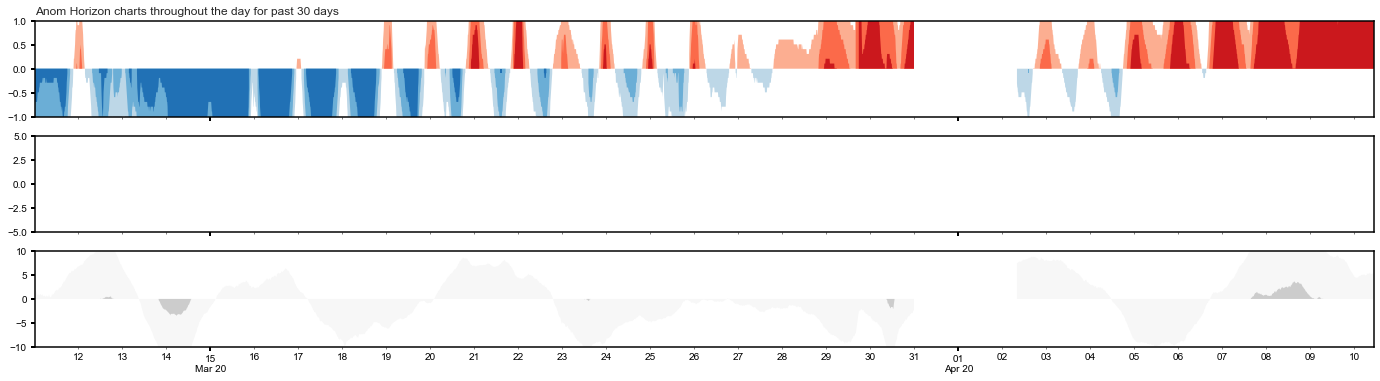

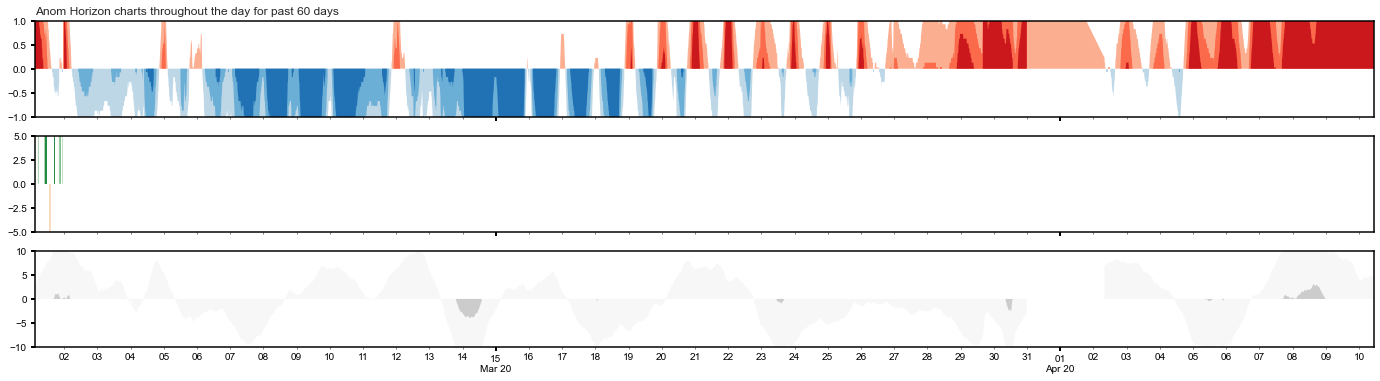

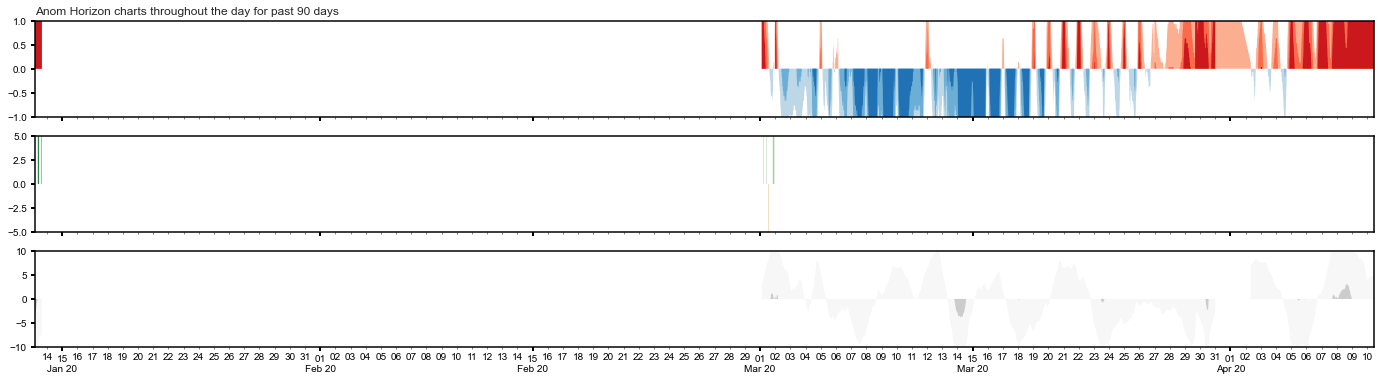

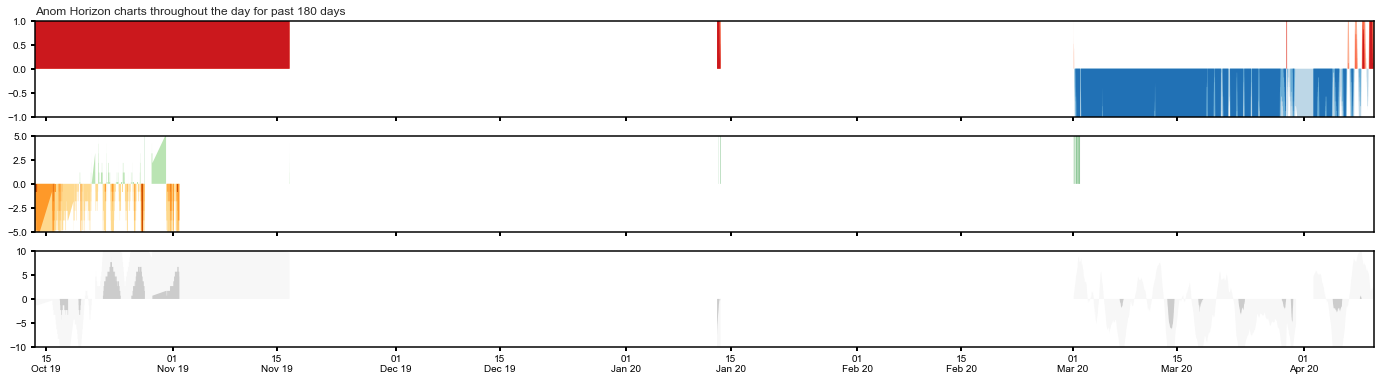

In [24]:

# Horizon Plots
dayperiod = [30,60,90,180]

for numdays in dayperiod:

    #df=df.resample('T').mean()
    df[df.SLP>1500] = np.nan
    df[df.Barotemperature>50] = np.nan
    
    dfsub = df[str((datetime.datetime.utcnow()-datetime.timedelta(days=numdays)).date()):str(datetime.datetime.utcnow().date())]
    anom = dfsub['Barotemperature']-dfsub['Barotemperature'].mean()

    fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex='col',figsize=(24,6))
    ax1.set_title(f'Anom Horizon charts throughout the day for past {numdays} days',loc='left')

    ax1.fill_between(dfsub.index.values,anom,where=anom>0,facecolor='#fcae91')
    ax1.fill_between(dfsub.index.values,anom-1,where=anom>1,facecolor='#fb6a4a')
    ax1.fill_between(dfsub.index.values,anom-2,where=anom>2,facecolor='#cb181d')
    ax1.fill_between(dfsub.index.values,anom,where=anom<0,facecolor='#bdd7e7')
    ax1.fill_between(dfsub.index.values,anom+1,where=anom<-1,facecolor='#6baed6')
    ax1.fill_between(dfsub.index.values,anom+2,where=anom<-2,facecolor='#2171b5')
    ax1.set_ylim([-1,1])

    anom = dfsub['RH_Percent']-dfsub['RH_Percent'].mean()
    ax2.fill_between(dfsub.index.values,anom,where=anom>0,facecolor='#bae4b3')
    ax2.fill_between(dfsub.index.values,anom-5,where=anom>5,facecolor='#74c476')
    ax2.fill_between(dfsub.index.values,anom-10,where=anom>10,facecolor='#238b45')
    ax2.fill_between(dfsub.index.values,anom,where=anom<0,facecolor='#fed98e')
    ax2.fill_between(dfsub.index.values,anom+5,where=anom<-5,facecolor='#fe9929')
    ax2.fill_between(dfsub.index.values,anom+10,where=anom<-10,facecolor='#cc4c02')
    ax2.set_ylim([-5,5])

    anom = (dfsub['SLP']-dfsub['SLP'].mean())
    ax3.fill_between(dfsub.index.values,anom,where=anom>0,facecolor='#f7f7f7')
    ax3.fill_between(dfsub.index.values,anom-10,where=anom>10,facecolor='#cccccc')
    ax3.fill_between(dfsub.index.values,anom-20,where=anom>20,facecolor='#969696')
    ax3.fill_between(dfsub.index.values,anom,where=anom<0,facecolor='#f7f7f7')
    ax3.fill_between(dfsub.index.values,anom+10,where=anom<-10,facecolor='#cccccc')
    ax3.fill_between(dfsub.index.values,anom+20,where=anom<-20,facecolor='#969696')
    ax3.set_ylim([-10,10])

    xfmt = mdates.DateFormatter('%d-%b')
    ax1.xaxis.set_major_formatter(xfmt)
    ax2.xaxis.set_major_formatter(xfmt)
    ax3.xaxis.set_major_formatter(xfmt)
    ax1.set_xlim(dfsub.index.min(),dfsub.index.max())
    ax2.set_xlim(dfsub.index.min(),dfsub.index.max())
    ax3.set_xlim(dfsub.index.min(),dfsub.index.max())
    
    ax1.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
    if numdays <=90:
        ax1.xaxis.set_minor_locator(DayLocator(range(0,32,1)))
    ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
    ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
    ax1.xaxis.set_tick_params(which='major', pad=3)
    ax1.xaxis.set_tick_params(which='minor', pad=5)    

